In [1]:
# % % bash
# !(stat - t / usr/local/lib/*/dist-packages/google/colab > /dev/null 2 > &1) & & exit
# rm - rf 68611-hw2


In [2]:
import sys
import os
os.makedirs("68611-hw2", exist_ok=True)
sys.path.append("./68611-hw2")


In [3]:
!pip install sacrebleu


# **Part 0: Data Loading and Preprocessing**

In this section we will load the data that we will be using throughout the lab and perform some preprocessing steps. We will also define some functions that will be useful for training and evaluating your models. You do not need to write any code for this part, but you are encouraged to read through the code carefully and make sure you understand it.

First we download the data. The dataset consists of parallel English and Vietnamese sentences (IWSLT'15 English-Vietnamese translation data). In the first two parts of the lab, you will do language modeling using only the English data, and in the final part of the lab you will do translation from Vietnamese to English.

In [4]:
# Download data
# !wget - nv - O ./68611-hw2/train.en https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
# !wget - nv - O ./68611-hw2/train.vi https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
# !wget - nv - O ./68611-hw2/tst2013.en https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
# !wget - nv - O ./68611-hw2/tst2013.vi https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
# !wget - nv - O ./68611-hw2/vocab.en https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
# !wget - nv - O ./68611-hw2/vocab.vi https: // nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi


Next we read and store the data.

In [5]:
def read_sentence_file(filename):
    sentences_list = []
    with open(filename, "r") as f:
        for line in f:
            sentences_list.append(line.strip().split())
    return sentences_list


def read_vocab_file(filename):
    with open(filename, "r") as f:
        return [line.strip() for line in f]


src_vocab_set = read_vocab_file(os.path.join("./68611-hw2", "vocab.vi"))
trg_vocab_set = read_vocab_file(os.path.join("./68611-hw2", "vocab.en"))

train_src_sentences_list = read_sentence_file(os.path.join("./68611-hw2",
                                                           "train.vi"))
train_trg_sentences_list = read_sentence_file(os.path.join("./68611-hw2",
                                                           "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file(os.path.join("./68611-hw2",
                                                          "tst2013.vi"))
test_trg_sentences_list = read_sentence_file(os.path.join("./68611-hw2",
                                                          "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)


Next we do preprocessing on the dataset, and we perform a preliminary data analysis.

Number of training (src, trg) sentence pairs: 108748
Number of validation (src, trg) sentence pairs: 12083
Number of testing (src, trg) sentence pairs: 1139
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17192
Training sentence avg. length: 20 
Training sentence length at 95-percentile: 42
Training sentence length distribution (x-axis is length range and y-axis is count):



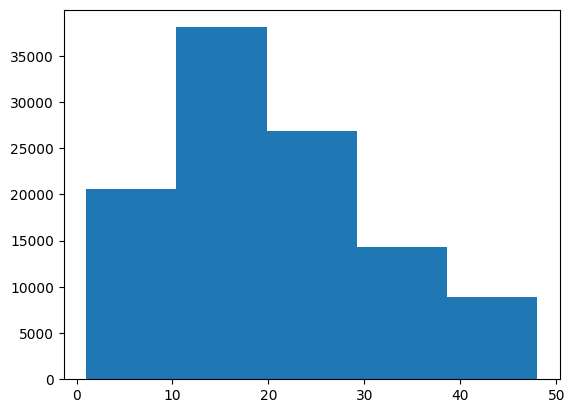

Example Vietnamese input: ['Adam', 'Sadowsky', 'dàn', 'dựng', '1', 'video', 'âm', 'nhạc', 'hiện', 'tượng', '.']
Its target English output: ['Adam', 'Sadowsky', ':', 'How', 'to', 'engineer', 'a', 'viral', 'music', 'video']


In [6]:
import numpy as np
import matplotlib.pyplot as plt


MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

# We only keep sentences that do not exceed 48 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 50 words.


def filter_data(src_sentences_list, trg_sentences_list, max_len):
    new_src_sentences_list, new_trg_sentences_list = [], []
    for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
        if (len(src_sent) <= max_len and len(trg_sent) <= max_len
                and len(src_sent) > 0 and len(trg_sent)) > 0:
            new_src_sentences_list.append(src_sent)
            new_trg_sentences_list.append(trg_sent)
    return new_src_sentences_list, new_trg_sentences_list


train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, max_len=MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, max_len=MAX_SENT_LENGTH)

# We take 10% of the training data to be the validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))
src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[0]))
print('Its target English output: ' + str(train_trg_sentences_list[0]))


Here we setup our PyTorch environment.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


We define custom dataset classes for both the language modeling task and the machine translation task so that we can use PyTorch's built-in dataset tools.

In [8]:
from torch.utils import data


# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class LMDataset(data.Dataset):
    def __init__(self, src_sentences, src_vocabs, sampling=1.):
        self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]

        self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

        self.src_vocabs = src_vocabs

        self.src_v2id = {v: i for i, v in enumerate(src_vocabs)}
        self.src_id2v = {val: key for key, val in self.src_v2id.items()}

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, index):
        sent = self.src_sentences[index]
        sent_len = len(sent) + 2   # add <s> and </s> to each sentence
        sent_id = []
        for w in sent:
            if w not in self.src_vocabs:
                w = '<unk>'
            sent_id.append(self.src_v2id[w])
        src_id = ([SOS_INDEX] + sent_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_src_seq_length - sent_len))
        trg_id = (sent_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_src_seq_length - sent_len + 1))

        return torch.tensor(src_id), sent_len, torch.tensor(trg_id), sent_len


class MTDataset(data.Dataset):
    def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
                 sampling=1.):
        self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
        self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

        self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
        self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

        self.src_vocabs = src_vocabs
        self.trg_vocabs = trg_vocabs

        self.src_v2id = {v: i for i, v in enumerate(src_vocabs)}
        self.src_id2v = {val: key for key, val in self.src_v2id.items()}
        self.trg_v2id = {v: i for i, v in enumerate(trg_vocabs)}
        self.trg_id2v = {val: key for key, val in self.trg_v2id.items()}

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, index):
        src_sent = self.src_sentences[index]
        src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
        src_id = []
        for w in src_sent:
            if w not in self.src_vocabs:
                w = '<unk>'
            src_id.append(self.src_v2id[w])
        src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_src_seq_length - src_len))

        trg_sent = self.trg_sentences[index]
        trg_len = len(trg_sent) + 2
        trg_id = []
        for w in trg_sent:
            if w not in self.trg_vocabs:
                w = '<unk>'
            trg_id.append(self.trg_v2id[w])
        trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_trg_seq_length - trg_len))

        return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len


Next we instantiate our datasets and data loaders. The data loaders are what we will iterate over when training and evaluating our models.

In [9]:
batch_size = 128  # note that this is a hyperparameter you may want to adjust

lm_train_set = LMDataset(train_trg_sentences_list, trg_vocab_set, sampling=1.)
lm_train_data_loader = data.DataLoader(lm_train_set, batch_size=batch_size,
                                       num_workers=8, shuffle=True)

lm_val_set = LMDataset(val_trg_sentences_list, trg_vocab_set, sampling=1.)
lm_val_data_loader = data.DataLoader(lm_val_set, batch_size=batch_size, num_workers=8,
                                     shuffle=False)

# You can try on a smaller training set by setting a smaller `sampling`.
mt_train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                         train_trg_sentences_list, trg_vocab_set, sampling=1.)
mt_train_data_loader = data.DataLoader(mt_train_set, batch_size=batch_size,
                                       num_workers=8, shuffle=True)

mt_val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                       val_trg_sentences_list, trg_vocab_set, sampling=1.)
mt_val_data_loader = data.DataLoader(mt_val_set, batch_size=batch_size, num_workers=8,
                                     shuffle=False)


Now we define the functions that will actually carry out the training process. You are strongly encouraged to read these carefully; doing so will likely save you time as you work on your model implementations.

One important point to take note of here is that while in class we discussed using basic stochastic gradient descent (SGD) for our optimization method, in practice it is often better to use optimizers with adaptive learning rates, such as the Adam optimizer that we use here, the details of which you can find in [this paper](https://arxiv.org/abs/1412.6980).

In [10]:
import math


class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:  # training mode
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, task, print_every):
    """Standard Training and Logging Function"""

    total_tokens = 0
    total_loss = 0

    for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
        # We define some notations here to help you understand the loaded tensor
        # shapes:
        #   `B`: batch size
        #   `T`: max sequence length of source sentences
        #   `L`: max sequence length of target sentences; due to our preprocessing
        #        in the beginning, `L` == `T` == 50
        # An example of `src_ids_BxT` (when B = 2):
        #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
        #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
        # The corresponding `src_lengths_B` would be [47, 49].
        # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

        src_ids_BxT = src_ids_BxT.to(device)
        src_lengths_B = src_lengths_B.to(device)
        trg_ids_BxL = trg_ids_BxL.to(device)
        del trg_lengths_B   # unused

        if task == "seq2seq":
            _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

            loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                                norm=src_ids_BxT.size(0))
            total_loss += loss
            total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()
        elif task == "lm":
            output = model(src_ids_BxT)

            loss = loss_compute(x=output, y=trg_ids_BxL,
                                norm=src_ids_BxT.size(0))
            total_loss += loss
            total_tokens += (trg_ids_BxL != PAD_INDEX).data.sum().item()
        else:
            raise ValueError("unknown task")

        if model.training and i % print_every == 0:
            print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

    return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, train_data_loader, val_data_loader, task, print_every):
    # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
    # computing the loss.
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Keep track of dev perplexity for each epoch.
    dev_ppls = []

    for epoch in range(1, 1+num_epochs):
        print("Epoch", epoch)

        model.train()
        train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                              loss_compute=SimpleLossCompute(model.generator,
                                                             criterion, optim),
                              task=task,
                              print_every=print_every)

        model.eval()
        with torch.no_grad():
            dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                                loss_compute=SimpleLossCompute(model.generator,
                                                               criterion, None),
                                task=task,
                                print_every=print_every)
            print("Validation perplexity: %f" % dev_ppl)
            dev_ppls.append(dev_ppl)

    return dev_ppls


We provide a function for visualizing your models' learning curves.

In [11]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)


This function takes a hidden state, performs a linear transformation on it, and finally takes a log softmax. Note the usage of this class within the above training functions.

In [12]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""

    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


Here we define decoding functions for performing inference with our Encoder-Decoder model.

In [13]:
def greedy_decode(model, src_ids, src_lengths, max_len):
    """Greedily decode a sentence for EncoderDecoder."""

    with torch.no_grad():
        encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
        prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

    output = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            hidden, outputs = model.decode(
                encoder_finals, prev_y, encoder_hiddens, hidden)
            prob = model.generator(outputs[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

    output = np.array(output)

    # Cut off everything starting from </s>.
    first_eos = np.where(output == EOS_INDEX)[0]
    if len(first_eos) > 0:
        output = output[:first_eos[0]]
    return output


def lookup_words(x, vocab):
    return [vocab[i] for i in x]


You will use this function to visualize some examples once you have trained your translation model.

In [14]:
def print_examples(model, data_loader, n=3,
                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS,
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
    """Prints `n` examples. Assumes batch size of 1."""

    model.eval()

    for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
        if isinstance(model, EncoderDecoder):
            result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                                   max_len=max_len)
        else:
            raise NotImplementedError("Unknown model type.")

        # remove <s>
        src_ids = src_ids[0, 1:]
        trg_ids = trg_ids[0, 1:]
        # remove </s> and <pad>
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
        trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

        print("Example #%d" % (i + 1))
        print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
        print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
        print()

        if i == n - 1:
            break


The following function will allow you to evaluate your translation model's BLEU score on a test dataset.

In [15]:
import sacrebleu
from tqdm import tqdm


def compute_BLEU(model, data_loader):
    bleu_score = []

    model.eval()
    for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
        if isinstance(model, EncoderDecoder):
            result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
        else:
            raise NotImplementedError("Unknown model type.")

        # remove <s>
        src_ids = src_ids[0, 1:]
        trg_ids = trg_ids[0, 1:]
        # remove </s> and <pad>
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
        trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

        pred = " ".join(lookup_words(result, vocab=trg_vocab_set))
        targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab_set))

        bleu_score.append(sacrebleu.raw_corpus_bleu(
            [pred], [[targ]], .01).score)

    return bleu_score


# **Part 2: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN language model. You are not allowed to use the PyTorch built-in RNN module (or the corresponding LSTM and GRU modules), but you may use the RNNCell (https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html) module (or the LSTMCell/GRUCell modules).

In [16]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, src_embed, generator):
        """
        Inputs:
          - `input_size`: a positive integer corresponding to the size of the
              word embeddings
          - `hidden_size`: a positive integer representing the dimensionality of
              the RNN's hidden state vector
          - `src_embed`: an nn.Embedding object representing the lookup table for
              input (source) sentences
          - `generator`: a `Generator` object. Essentially a linear mapping
              followed by a softmax. You should not call it within this class; it
              is called in the SimpleLossCompute class above
        """
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        self.hidden_size = hidden_size
        self.src_embed = src_embed
        self.generator = generator
        # hint: unless you choose to implement the RNN update equations yourself
        #       you will want a `self.rnn` module that does that for you, which
        #       is where the RNNCell/LSTMCell/GRUCell modules come in handy

        ### Your code here! ###
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        ###

    def init_hidden(self, batch_size):
        """
        Input:
          - `batch_size`: a positive integer

        Returns:
          - `hidden`: a 2d-tensor of shape (batch_size, hidden_size) representing
              the initial hidden state of the RNN
        """
        # Use to initialize hidden state everytime before running a sentence.
        hidden = torch.zeros(batch_size, self.hidden_size).to(device)
        return hidden

    def forward(self, input_ids):
        """
        Given a sequence of words (represented as IDs), compute and return the
        hidden state at each timestep (equivalently, for each input word).
        Input:
          - `input_ids`: a 2d-tensor of shape
             (batch_size, MAX_SENT_LENGTH_PLUS_SOS_EOS) representing a batch of
             sentences from the dataset (with IDs instead of words)

        Returns:
          - `hiddens`: a 3d-tensor of shape
              (batch_size, MAX_SENT_LENGTH_PLUS_SOS_EOS, hidden_size) representing
              the hidden state of the model at each timestep
        """
        # hint: pay close attention to the shapes of your tensors; you may find
        #       pytorch's `permute()` method for tensors useful

        ### Your code here! ###
        batch_size, max_length = input_ids.shape
        inputs_embed = self.src_embed(input_ids) # (batch_size, max_length, hidden_size)
        inputs_embed = torch.permute(inputs_embed, (1, 0, 2))

        hx = self.init_hidden(batch_size).to(device)  # (batch_size, hidden_size)
        cx = self.init_hidden(batch_size).to(device)  # (batch_size, hidden_size)
        hiddens = []
        for i in inputs_embed:
            hx, cx = self.lstm(i, (hx, cx))
            hiddens.append(hx)
        hiddens = torch.stack(hiddens)
        hiddens = torch.permute(hiddens, (1, 0, 2))
        ###

        return hiddens


Once you have implemented your model, run this cell to train and evaluate it. Note that the hyperparameters chosen here (including `learning_rate`) are not necessarily optimal—you may want to adjust them to improve performance. A simple one-layer implementation of a vanilla RNN should yield a perplexity in the 70s or 80s, but you can do better by adding layers, implementing a GRU/LSTM, and/or optimizing hyperparameters.

NOTE THAT IT MIGHT TAKE A WHILE (13 MINS) TO TRAIN FOR 10 EPOCHS (plan accordingly). 

Epoch 1
Epoch Step: 0 Loss: 177.950455
Epoch Step: 100 Loss: 102.731422
Epoch Step: 200 Loss: 91.158371
Epoch Step: 300 Loss: 90.025574
Epoch Step: 400 Loss: 84.725777
Epoch Step: 500 Loss: 88.754013
Epoch Step: 600 Loss: 78.793274
Epoch Step: 700 Loss: 81.337242
Epoch Step: 800 Loss: 92.325653
Validation perplexity: 108.965036
Epoch 2
Epoch Step: 0 Loss: 84.346191
Epoch Step: 100 Loss: 78.236000
Epoch Step: 200 Loss: 78.417595
Epoch Step: 300 Loss: 80.983109
Epoch Step: 400 Loss: 81.712090
Epoch Step: 500 Loss: 80.128029
Epoch Step: 600 Loss: 83.543282
Epoch Step: 700 Loss: 77.890350
Epoch Step: 800 Loss: 78.061096
Validation perplexity: 90.103362
Epoch 3
Epoch Step: 0 Loss: 81.626938
Epoch Step: 100 Loss: 83.430351
Epoch Step: 200 Loss: 74.286392
Epoch Step: 300 Loss: 81.782913
Epoch Step: 400 Loss: 80.379715
Epoch Step: 500 Loss: 72.278511
Epoch Step: 600 Loss: 70.919479
Epoch Step: 700 Loss: 80.240227
Epoch Step: 800 Loss: 69.879402
Validation perplexity: 82.848382
Epoch 4
Epoch St

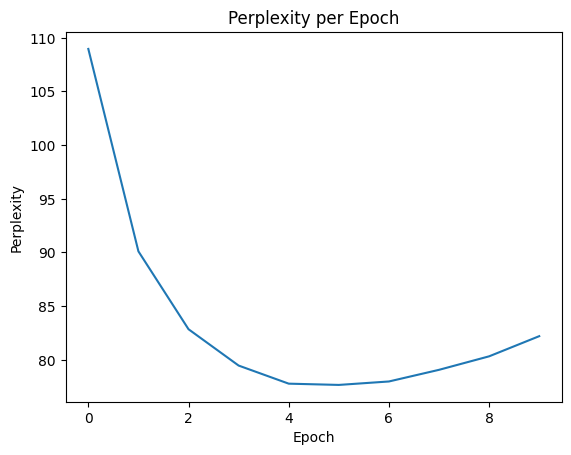

In [17]:
# Each word will be represented as a `embed_size`-dim vector.
embed_size = 256
hidden_size = 256

# model itself
rnn_lm = RNN(input_size=embed_size,
             hidden_size=hidden_size,
             src_embed=nn.Embedding(len(trg_vocab_set), embed_size),
             generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

# list of epoch perplexities from training
lm_dev_ppls = train(rnn_lm, num_epochs=10,
                    learning_rate=1e-3,
                    train_data_loader=lm_train_data_loader,
                    val_data_loader=lm_val_data_loader,
                    task="lm", print_every=100)

plot_perplexity(lm_dev_ppls)


# **Part 3: Seq2Seq Model**



In this part of the lab, you will explore seq2seq to perform a machine translation task. The main task is to implement the naive encoder-decoder architecture without attention.

In machine translation (MT), your goal is to translate the correct sentence meaning into another language. In our case, we want to translate Vietnamese sentences into English sentences. See the diagram below for an illustration of how the translation process works with an encoder-decoder architecture.

Note that this default Encoder-Decoder sequence-to-sequence model that you will implement is not at all good enough to function as a realistic machine translation system.
For those interested, feel free to experiment with the model to try to improve it! 

Some possible suggestions include:
- Playing around with basic hyperparameters (model size, dropout, learning rate, etc.)
- Experimenting with different RNN Cells (GRU/LSTM)
- Exploring attention-based models (quite difficult)
- Using beam search instead of greedy search (moderately difficult)

Feel free to alter the signatures / write helper functions for the below classes.

![picture](https://drive.google.com/uc?id=1VQMgKh6AdxcJZiw7qO7cE_MHyiAAu62b)

## Encoder

We will start with a single-layer unidirectional GRU. You are free to try bidirectional and stack more layers. Note that we are now including *dropout* in our model. Dropout is essentially a regularization technique in which a specified proportion of the model parameters are randomly ignored during a given forward and backward pass of the model. If you want a more detailed explanation, see [this paper](https://arxiv.org/abs/1409.2329) which discusses dropout in the context of RNNs.

In [18]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        """
        Inputs: 
          - `input_size`: an int representing the RNN input size.
          - `hidden_size`: an int representing the RNN hidden size.
          - `dropout`: a float representing the dropout rate during training. Note
              that for 1-layer RNN this has no effect since dropout only applies to
              outputs of intermediate layers.
        """
        super(Encoder, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True,
                          dropout=dropout, bidirectional=False)

    def forward(self, inputs, lengths):
        """
        Inputs:
          - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
              representing a batch of padded embedded word vectors of source
              sentences.
          - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
              lengths of `inputs`.

        Returns:
          - `outputs`: a 3d-tensor of shape
            (batch_size, max_seq_length, hidden_size).
          - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
          Hint: `outputs` and `finals` are both standard GRU outputs. Check:
          https://pytorch.org/docs/stable/nn.html#gru
        """
        # Our variable-length inputs are padded to the same length for batching
        # Here we "pack" them for computational efficiency (see note below)
        packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True,
                                      enforce_sorted=False)
        outputs, finals = self.rnn(packed)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True,
                                         total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)
        return outputs, finals


Note: For a clear explanation of padding and packing, see the second answer to this [stackoverflow question](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch).

## Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 

In [19]:
class Decoder(nn.Module):
    """An RNN decoder. Optionally add attention using the scaffolding function. """

    def __init__(self, input_size, hidden_size, dropout=0.):
        """
          Inputs:
            - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
        """
        super(Decoder, self).__init__()

        # hint 1: while the encoder just needed a single RNN layer, more will be
        #         required for the decoder.
        # hint 2: think about what you'll need in init_hidden(self, encoder_finals)
        # hint 3: what will you use to compute the pre_output (see docstring of
        #         forward function)?

        ### Your code here! ###
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True,
                          dropout=dropout, bidirectional=True)
        ###

    def forward_step(self, prev_embed, hidden):
        """Helper function for forward below:
           Perform a single decoder step (1 word).

           Inputs:
          - `prev_embed`: a 3d-tensor of shape (batch_size, 1, embed_size)
              representing the padded embedded word vectors at this step in training
          - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
              the current hidden state.

          Returns:
          - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
              representing the current decoder hidden state.
          - `pre_output`: a 3d-tensor of shape (batch_size, 1, hidden_size)
              representing the total decoder output for one step
        """
        # hint: you'll want to do more here than just run self.rnn (think about
        #       what you should do to the output of the self.rnn in order to
        #       compute the `pre_output`)

        ### Your code here! ###
        pre_output, hidden = self.rnn(prev_embed, hidden)
        ###

        return hidden, pre_output

    def forward(self, inputs, encoder_finals, encoder_hiddens, hidden=None, max_len=None):
        """Unroll the decoder one step at a time.

        Inputs:
          - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
              representing a batch of padded embedded word vectors of target
              sentences (for teacher-forcing during training). (during evaluation, 
              we instead have the model's previously-predicted best word).
          - `encoder_finals`: a 3d-tensor of shape
              (num_enc_layers, batch_size, hidden_size) representing the final
              encoder hidden states used to initialize the initial decoder hidden
              states.
          - `encoder_hiddens` (only needed for attention): a 3d-tensor of shape 
              (batch_size, max_seq_length, hidden_size) representing the hidden state
              at each point in the encoder sequence. 
          - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
              the value to be used to initialize the initial decoder hidden states.
              If None, then use `encoder_finals`.
          - `max_len`: an int representing the maximum decoding length.

        Returns:
          - `hidden`: a 3d-tensor of shape
              (num_layers, batch_size, hidden_size) representing the final hidden
              state for each element in the batch.
          - `pre_output_vectors`: a 3d-tensor of shape
              (batch_size, max_len, hidden_size) representing the raw decoder
              outputs (before mapping to a `trg_vocab_size`-dim vector).
        """

        # The maximum number of steps to unroll the RNN.
        if max_len is None:
            max_len = inputs.size(1)

        # Initialize decoder hidden state.
        if hidden is None:
            hidden = self.init_hidden(encoder_finals)

        # hint: you'll want to keep track of the `pre_output` for each timestep,
        #       but you only need the final `hidden` state

        ### Your code here! ###
        pre_output_vectors = []
        for i in range(inputs.shape[1]):
            hidden, pre_output = self.forward_step(inputs[:, i:i+1, :], hidden)
            pre_output_vectors.append(pre_output)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        ###

        return hidden, pre_output_vectors

    def init_hidden(self, encoder_finals):
        """Use encoder final hidden state to initialize decoder's first hidden
           state.

           Input: `encoder_finals` is same as in forward()

           Returns: 
             - `decoder_init_hiddens`: a 3d-tensor of shape 
                  (num_layers, batch_size, hidden_size) representing the initial
                  hidden state of the decoder for each element in the batch 
        """
        # hint: think about whether or not an activation function is needed here

        ### Your code here! ###
        decoder_init_hiddens = torch.cat((encoder_finals, encoder_finals), dim=0)

        ###
        return decoder_init_hiddens

    def attention(self, hidden, encoder_hiddens):
        """Compute the context vector at the current step. (optional)

        Inputs:
          - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
              representing the current decoder hidden state.
          - `encoder_hiddens`: a 3d-tensor of shape 
              (batch_size, max_seq_length, hidden_size) representing the hidden state
              at each point in the encoder sequence. 

        Returns:
          - `context`: a 3d-tensor of shape (batch_size, 1, hidden_size) representing
              the context vector attained from attending the decoder hidden state to 
              the encoder states.     

        Note: You might find torch.permute() helpful to get your tensors in the
              right shape.
        """
        ### Your code here! ###

        ###
        pass


## Encoder-Decoder

Here we define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings. There are solutions in which you do not need to write any code for this module, but your implementation of the above moudles might require some code to be written.

In [20]:
class EncoderDecoder(nn.Module):
    """A standard Encoder-Decoder architecture without attention.
    """

    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        """
        Inputs:
          - `encoder`: an `Encoder` object.
          - `decoder`: an `Decoder` object.
          - `src_embed`: an nn.Embedding object representing the lookup table for
              input (source) sentences.
          - `trg_embed`: an nn.Embedding object representing the lookup table for
              output (target) sentences.
          - `generator`: a `Generator` object. Essentially a linear mapping. See
              the next code cell.
        """
        super(EncoderDecoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator

    def forward(self, src_ids, trg_ids, src_lengths):
        """Take in and process masked source and target sequences.

        Inputs:
          `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of source sentences of word ids.
          `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of target sentences of word ids.
          `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
            sequence length of `src_ids`.

        Returns the decoder outputs, see the above cell.
        """
        encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
        return self.decode(encoder_finals, trg_ids[:, :-1], encoder_hiddens)

    def encode(self, src_ids, src_lengths):
        return self.encoder(self.src_embed(src_ids), src_lengths)

    def decode(self, encoder_finals, trg_ids, encoder_hiddens, decoder_hidden=None):
        return self.decoder(self.trg_embed(trg_ids), encoder_finals, encoder_hiddens, decoder_hidden)


Once you have implemented your model, run this cell to train and evaluate your model. Note that the hyperparameters chosen here (including `learning_rate`) are not necessarily optimal—you may want to adjust them to improve performance. A reasonable perplexity here would be in the low- to mid-30s after 10 epochs of training.

/home/swtian/.virtualenvs/pset/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.3/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


Epoch Step: 0 Loss: 178.457413
Epoch Step: 100 Loss: 100.054924
Epoch Step: 200 Loss: 92.377563
Epoch Step: 300 Loss: 82.373840
Epoch Step: 400 Loss: 84.310783
Epoch Step: 500 Loss: 85.545074
Epoch Step: 600 Loss: 84.491463
Epoch Step: 700 Loss: 81.028595
Epoch Step: 800 Loss: 77.643951
Validation perplexity: 70.965154
Epoch 2
Epoch Step: 0 Loss: 71.059090
Epoch Step: 100 Loss: 73.384911
Epoch Step: 200 Loss: 75.756966
Epoch Step: 300 Loss: 72.745193
Epoch Step: 400 Loss: 76.575287
Epoch Step: 500 Loss: 68.495506
Epoch Step: 600 Loss: 70.133148
Epoch Step: 700 Loss: 70.343887
Epoch Step: 800 Loss: 67.737030
Validation perplexity: 52.283309
Epoch 3
Epoch Step: 0 Loss: 62.365131
Epoch Step: 100 Loss: 67.487442
Epoch Step: 200 Loss: 67.693115
Epoch Step: 300 Loss: 63.385948
Epoch Step: 400 Loss: 59.158642
Epoch Step: 500 Loss: 67.310005
Epoch Step: 600 Loss: 63.061592
Epoch Step: 700 Loss: 62.283810
Epoch Step: 800 Loss: 62.462387
Validation perplexity: 45.347614
Epoch 4
Epoch Step: 0 Los

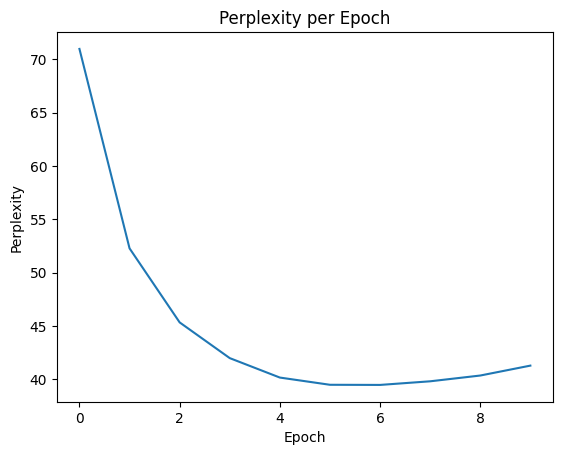

In [21]:
# Hyperparameters for contructing the encoder-decoder model.

# Each word will be represented as a `embed_size`-dim vector.
embed_size = 256
hidden_size = 256  # RNN hidden size.
dropout = 0.2

# model itsef
pure_seq2seq = EncoderDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=Decoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(src_vocab_set), embed_size),
    trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
    generator=Generator(2*hidden_size, len(trg_vocab_set))).to(device)

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                      train_data_loader=mt_train_data_loader,
                      val_data_loader=mt_val_data_loader,
                      task="seq2seq", print_every=100)

plot_perplexity(pure_dev_ppls)


Run the following cell to visualize some of the translations produced by your model.

In [22]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(mt_val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print_examples(pure_seq2seq, example_data_loader)


Example #1
Src :  Khoa học đằng sau một tiêu đề về khí hậu
Trg :  Rachel <unk> : The science behind a climate headline
Pred:  <unk> , a little bit about the <unk> .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred:  I want to show you what the scientists are going to learn to do is to understand the most exciting thing about the art of the audience .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Trg :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Pred:  These are things like this , like <unk> or Jose <unk> and <unk> , <unk> , <unk> , <unk> , <unk> 

For translation, BLEU score gives a better measure of performance than perplexity. Run this cell to compute your model's BLEU score on a test dataset. A reasonable BLEU score would be something around 6.

In [23]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print(np.mean(compute_BLEU(pure_seq2seq, test_data_loader)))


100%|██████████| 1139/1139 [00:29<00:00, 38.45it/s]

5.531097600270609
